<h3>Importando as bibliotecas do Python<h3>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from matplotlib import pyplot as plt

<h3>Leitura da base de treino<h3>

In [ ]:
df = pd.read_csv('train.csv', index_col='Id')

<h3>Definindo as variáveis (Questão 1)<h3>

In [ ]:
#Variáveis criadas em aula
df['AgeSold']      = df['YrSold'] - df['YearBuilt']
df['AgeRemodSold'] = df['YrSold'] - df['YearRemodAdd']

Primeiramente transformamos alguns parâmetros não numéricos que podem ser quantificados lendo-se a descrição da base.

In [ ]:
#Dicionário street
repStDic = {
    'Grvl' : 1,	
    'Pave' : 2   
}

#Dicionário utilities
repUtiDic = {
    'AllPub' : 4,	
    'NoSewr' : 3,
    'NoSeWa' : 2,
    'ELO' : 1
}

#Dicionário variáveis de qualidade e condição
repQualCondDic = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1,
    'NA' : 0
}

df = df.replace({'Street' : repStDic, 'Utilities' : repUtiDic, 'ExterQual' : repQualCondDic, 'ExterCond' : repQualCondDic,
                 'KitchenQual' : repQualCondDic, 'FireplaceQu' : repQualCondDic, 'GarageQual' : repQualCondDic, 
                 'GarageCond' : repQualCondDic, 'PoolQC' : repQualCondDic})

#Novas variáveis
df['ExterQualCond'] = df['ExterQual'] * df['ExterCond']
df['GarageQualCond'] = df['GarageQual'] * df['GarageCond']
df['FloorsFeet'] = df['1stFlrSF'] + df['2ndFlrSF']

*   ExterQualCond: parâmetro que relaciona a qualidade e condição do material utilizado na parte externa da casa.
*   GarageQualCond: parâmetro que relaciona a qualidade e condição da garagem.
*   FloorsFeet: soma do tamanho do primeiro e segundo andar da casa.

Para o caso dos dois primeiros parâmetros, temos o interesse de utilizá-los, pois correlacionando-os tem relação com as condições da casa. O terceiro parâmetro foi utilizado no intuito de levar em conta apenas o tamanho total da casa, independente do tamanho dos andares, para que no momento de aplicar o método ele não pese os parâmetros como se não estivessem correlacionados.



In [ ]:
target_col  = 'SalePrice'

future_cols = [
    'MoSold',
    'YrSold',
    'SaleType',
    'SaleCondition',
    target_col
]

drop_fe_cols = [
    'YearBuilt',
    'YearRemodAdd',
    'ExterQual',
    'ExterCond', 
    'GarageQual',
    'GarageCond', 
    '1stFlrSF',
    '2ndFlrSF'
]

In [ ]:
y = df['SalePrice']

# remover colunas futuras do X
X = df.drop(future_cols, axis=1)

# remove vars do feature eng
X.drop(drop_fe_cols, axis=1, inplace=True)

# remover todas as colunas nao numericas do X
obj_cols = X.columns[X.dtypes == object]
X.drop(obj_cols, axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.65,
    random_state=42
)

len(y_train), len(y_test)

In [ ]:
pipeline_num = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler' , MinMaxScaler())
    ]
)

ct = ColumnTransformer([
    (
        'num_transf', 
        pipeline_num, 
        make_column_selector(dtype_exclude=object)
    ),
    (
        'categ_transf', 
        OneHotEncoder(sparse=False, handle_unknown='ignore'), 
        make_column_selector(dtype_include=object)
    )
])

pipeline = Pipeline(
    steps=[
        ('ct', ct),
        # estimator: parametro que irá receber os modelos de regrassão
        ('estimator'     , KNeighborsRegressor() )
    ]
)

In [ ]:
# params_grid: parametros dos testes para cada modelo
# estimator: recebe a classe do modelo
# estimator__param: parametros especificos para cada modelo
params_grid = [
    {
    'ct__num_transf__imputer__strategy'    : ['mean', 'median'],
    'ct__num_transf__scaler'                : [MinMaxScaler(), StandardScaler()],

    'estimator'                            : [KNeighborsRegressor()],
    'estimator__n_neighbors'               : [11],
    'estimator__weights'                   : ['distance'],
    'estimator__metric'                    : ['manhattan']
    },
    {
    'ct__num_transf__imputer__strategy'    : ['mean', 'median'],
    'ct__num_transf__scaler'               : [MinMaxScaler(), StandardScaler()],
     
    'estimator'                            : [MLPRegressor()],
    'estimator__hidden_layer_sizes'        : [ (20, 5) ],
    'estimator__activation'                : ['relu'],
    'estimator__learning_rate'             : ['adaptive'],
    'estimator__max_iter'                  : [5000]
    },
    {
    'ct__num_transf__imputer__strategy'    : ['mean', 'median'],
    'ct__num_transf__scaler'               : [MinMaxScaler(), StandardScaler()],
     
    'estimator'                            : [LogisticRegression()]
    },
    {
    'ct__num_transf__imputer__strategy'    : ['mean', 'median'],
    'ct__num_transf__scaler'               : [MinMaxScaler(), StandardScaler()],
     
    'estimator'                            : [SVR()],
    'estimator__kernel'                    : [ 'linear', 'sigmoid' ]
},]

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
df_results = pd.DataFrame(grid_search.cv_results_)

df_results.to_excel('results.xlsx', index=False)

<h3> Gerar o resultado <h3>

In [ ]:
df_test = pd.read_csv('test.csv')

#Variáveis criadas em aula
df_test['AgeSold']      = df_test['YrSold'] - df_test['YearBuilt']
df_test['AgeRemodSold'] = df_test['YrSold'] - df_test['YearRemodAdd']

#Dicionário street
repStDic = {
    'Grvl' : 1,	
    'Pave' : 2   
}

#Dicionário utilities
repUtiDic = {
    'AllPub' : 4,	
    'NoSewr' : 3,
    'NoSeWa' : 2,
    'ELO' : 1
}

#Dicionário variáveis de qualidade e condição
repQualCondDic = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1,
    'NA' : 0
}

df_test = df_test.replace({'Street' : repStDic, 'Utilities' : repUtiDic, 'ExterQual' : repQualCondDic, 'ExterCond' : repQualCondDic,
                 'KitchenQual' : repQualCondDic, 'FireplaceQu' : repQualCondDic, 'GarageQual' : repQualCondDic, 
                 'GarageCond' : repQualCondDic, 'PoolQC' : repQualCondDic})

#Novas variáveis
df_test['ExterQualCond'] = df_test['ExterQual'] * df_test['ExterCond']
df_test['GarageQualCond'] = df_test['GarageQual'] * df_test['GarageCond']
df_test['FloorsFeet'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']

future_cols = [
    'MoSold',
    'YrSold',
    'SaleType',
    'SaleCondition'
]

drop_fe_cols = [
    'YearBuilt',
    'YearRemodAdd',
    'ExterQual',
    'ExterCond', 
    'GarageQual',
    'GarageCond', 
    '1stFlrSF',
    '2ndFlrSF',
    'PoolQC'
]

# remover colunas futuras do X
X = df_test.drop(future_cols, axis=1)

# remove vars do feature eng
X.drop(drop_fe_cols, axis=1, inplace=True)

# remover todas as colunas nao numericas do X
obj_cols = X.columns[X.dtypes == object]
X.drop(obj_cols, axis=1, inplace=True)

In [ ]:
df_result = pd.DataFrame(df_test['Id']).copy()
df_result['SalePrice'] = grid_search.predict(X)
df_result.to_csv("submission.csv", index=False)

<h3> Questão 3 <h3>

Submissão do resultado no Kaggle 

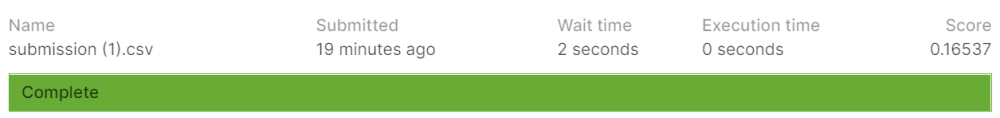

<h3>Questão 4<h3>

  Um possível problema com a métrica de erro RMSE é para quando existe algum outlier, pois terá um peso maior no cálculo do erro, prejudicando a métrica, isso ocorre pelo fato de que o erro nessa métrica é calculada pela raiz quadrada do erro quadrático médio. Outra métrica utilizada é a MAE onde calcula-se o erro absoluto médio, porém a RMSE no geral é mais interesse pois penaliza os erros maiores.







